# はじめに
機械学習モデルを公平性の観点から評価します。  

### 概要
- 収入を予測するモデルの予測が、性別によらず公平かどうかを評価します。  
- 公平性指標としてDemographic Parityを使用します。
- 公平性指標を考慮してモデルの学習を行った場合の公平性も評価します。

# 公平性指標  
### Demographic Parity  
今回考える公平性指標は、性別や人種などの各グループが公平に扱われているか（group fairness）を評価するために用いられます。  
Demographic Parityは、グループによらず各クラスが予測される確率が同じになっているかを評価する指標です。  
例えば、採用を判定するモデルで、男性と女性で採用確率が同じになっているかを評価する際に用いられます。

数式で書くと、性別や人種などの属性の集合を$A$、モデルが予測するクラスの集合を$\mathcal{Y}$、属性が$a \in A$のグループがクラス$\hat{y} \in \mathcal{Y}$と予測される確率を$P(\hat{y}|A=a)$とすると、任意の$\hat{y}, a, a'$で下記が成り立つ場合、モデルはDemographic Parityを満たします。

$$
P(\hat{y}|A=a) = P(\hat{y}|A=a')
$$

# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [1]:
import sys
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgb

!pip install fairlearn
from fairlearn.datasets import fetch_adult
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
from fairlearn.metrics import demographic_parity_difference, MetricFrame, selection_rate, count

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 1.4 MB/s eta 0:00:00


### 2. データセットの用意  
今回は[Adult Data Set](http://archive.ics.uci.edu/ml/datasets/adult)を使用します。  
年齢や教育歴などの14の属性から、収入が5万ドルを超えるかどうかを予測するタスクのデータセットで、48,842サンプルが含まれます。  
UCI Machine Learning Repositoryからダウンロードすることもできますが、Fairlearnのfetch_adultで取得します。

In [2]:
X, y = fetch_adult(return_X_y=True, as_frame=True)
print(X.head())
print(X.shape)
print(set(y))

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


    age  workclass    fnlwgt     education  education-num      marital-status  \
0  25.0    Private  226802.0          11th            7.0       Never-married   
1  38.0    Private   89814.0       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov  336951.0    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  160323.0  Some-college           10.0  Married-civ-spouse   
4  18.0        NaN  103497.0  Some-college           10.0       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male           0.0           0.0   
1    Farming-fishing      Husband  White    Male           0.0           0.0   
2    Protective-serv      Husband  White    Male           0.0           0.0   
3  Machine-op-inspct      Husband  Black    Male        7688.0           0.0   
4                NaN    Own-child  White  Female           0.0           0.0   

   hours-per-week native-country

データを7:3にランダムに分割して、それぞれを教師データとテストデータとして使用します。  
ラベルは、Fairlearnで用いられるように'>50K'は1、'<=50K'は0となるように変換しておきます。  

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
y_train = (y_train == '>50K') * 1
y_test = (y_test == '>50K') * 1

### 3. 学習  
LightGBMでモデルの学習を行います。  
テスト精度も確認しておきます。

In [4]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'accuracy',
}
model = lgb.LGBMClassifier(**lgb_params)
model.fit(X_train, y_train)

pred = model.predict(X_test)
print('test accuracy', accuracy_score(y_test, pred))

test accuracy 0.8799563229372824


### 4. 公平性評価
Fairlearnのdemographic_parity_differenceで、性別ごとのグループ間の不公平度を計算します。  
この関数は、sensitive_featuresに指定した属性のグループごとに、予測が1となる確率（selection rate）を計算し、グループ間の差の最大値を出力します。

In [5]:
demographic_parity_difference(y_test, pred, sensitive_features=X_test['sex'])

0.1862287222272065

グループごとの精度、selection rate、サンプル数をMetricFrameを用いて確認します。  
selection rateの差がdemographic_parity_differenceの値と一致していることも確認できます。  

accuracy              0.879956
selection rate        0.200437
count             14653.000000
dtype: float64
        accuracy  selection rate   count
sex                                     
Female  0.942074        0.075861  4851.0
Male    0.849214        0.262089  9802.0


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: title={'center': 'count'}, xlabel='sex'>]], dtype=object)

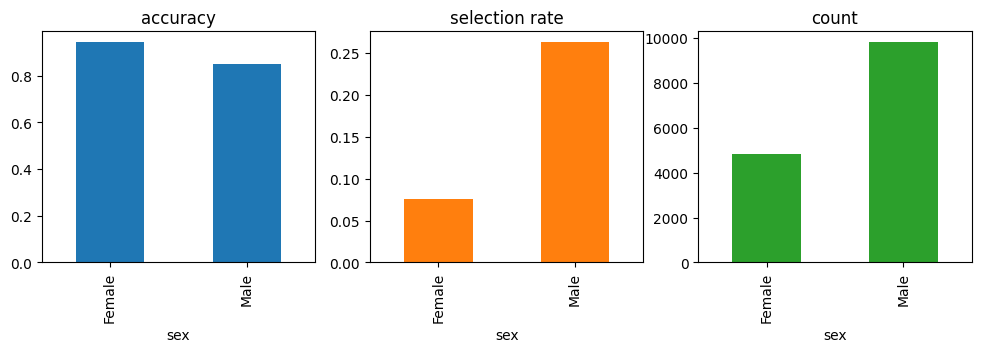

In [6]:
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection rate": selection_rate,
        "count": count,
    },
    sensitive_features=X_test['sex'],
    y_true=y_test,
    y_pred=pred,
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[1, 3],
    legend=False,
    figsize=[12, 3],
)

### 5. 公平性指標を考慮した学習  
FairlearnのExponentiatedGradientを用いて、公平性が改善するように学習を行います。

In [7]:
model_fair = lgb.LGBMClassifier(**lgb_params)
mitigator = ExponentiatedGradient(model_fair, DemographicParity())
mitigator.fit(X_train, y_train, sensitive_features=X_train['sex'])
pred = mitigator.predict(X_test)
print('test accuracy', accuracy_score(y_test, pred))

test accuracy 0.8579813007575241


先ほどと同様に公平性の評価を行います。

demographic parity differenct 0.026827389275286218
accuracy              0.857981
selection rate        0.178325
count             14653.000000
dtype: float64
        accuracy  selection rate   count
sex                                     
Female  0.903319        0.160379  4851.0
Male    0.835544        0.187207  9802.0


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: title={'center': 'count'}, xlabel='sex'>]], dtype=object)

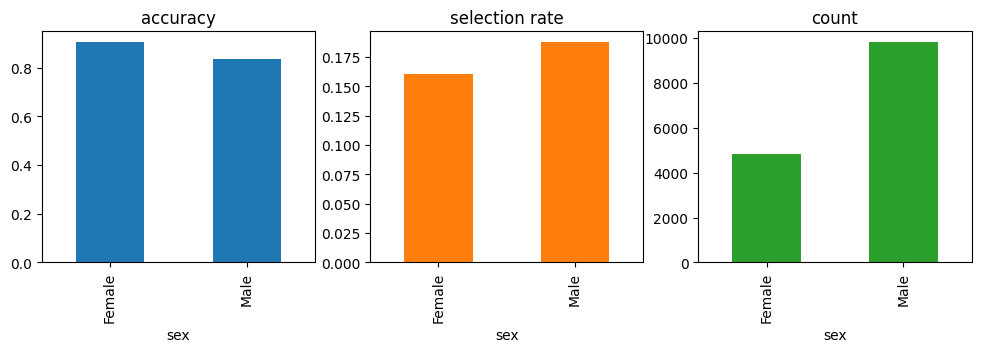

In [8]:
print('demographic parity differenct', demographic_parity_difference(y_test, pred, sensitive_features=X_test['sex']))
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection rate": selection_rate,
        "count": count,
    },
    sensitive_features=X_test['sex'],
    y_true=y_test,
    y_pred=pred,
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[1, 3],
    legend=False,
    figsize=[12, 3],
)

# おわりに

### 今回の結果
通常の学習では、Demographic Parityが満たされないこと、公平性を考慮した学習を行うことで、公平性を改善できることが確認できました。  
一方で、テスト精度は、公平性を考慮することで0.87から0.85に少し低下しています。  
公平性とテスト精度を両立できるかも重要な観点となります。  

### 次にやること
グループによらず収入が等しいとは限らないため、高収入と予測される確率を等しくするDemographic Parityに違和感を覚える方も多いと思います。  
別の公平性指標も検証したいと思います。

### 参考資料
- Adult Data Set  
http://archive.ics.uci.edu/ml/datasets/adult
- Fairlearn  
https://fairlearn.org/v0.8/quickstart.html

